# Importer les Librairies


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset,TensorDataset
from torchvision import datasets, transforms

import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import os
from PIL import Image

# Connexion aux GPUs

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Chemin vers les images

In [ ]:
chemin_images = && # Set the right path to the archive

# Importer les Images


In [5]:
# Importation des bibliothèques nécessaires
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Définition des transformations à appliquer aux images
transform = T.Compose([ 
    T.ToTensor(),  # Convertit l'image PIL ou NumPy en un tensor PyTorch
    T.Resize(64, antialias=True),  # Redimensionne l'image à 64x64 pixels avec anti-aliasing
    T.Normalize([.5, .5, .5], [.5, .5, .5])  # Normalise les images : (valeur - moyenne) / écart-type
])

# Chargement du dataset d'images à partir d'un répertoire
# 'chemin_images' doit être le chemin vers le dossier contenant les sous-dossiers d'images par classe
dataset = datasets.ImageFolder(root=chemin_images, transform=transform)

# Réduction de la taille du dataset si besoin (pour libérer de la place dans le CPU)
# n = 3000  # Nombre d'images à conserver
# dataset = Subset(dataset, range(n))  # Crée un sous-ensemble du dataset avec les n premières images

# Définition de la taille du batch pour le DataLoader
batchsize = 64  # Nombre d'images par mini-batch

# Création du DataLoader pour itérer sur le dataset par mini-batch
data_loader = DataLoader(
    dataset,         # Dataset à charger
    batch_size=batchsize,  # Taille de chaque mini-batch
    shuffle=True,    # Mélange les données à chaque époque
    drop_last=True   # Ignore la dernière batch si elle est plus petite que batch_size
)

# Visualiser quelques Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


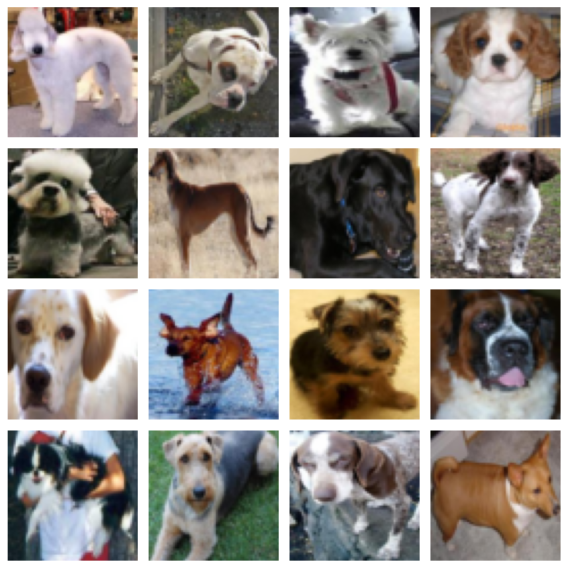

In [6]:
# Importation de matplotlib pour la visualisation
import matplotlib.pyplot as plt

# Récupération d'un batch de données du DataLoader
X, y = next(iter(data_loader))  # X contient les images, y contient les étiquettes

# Création d'une figure et d'un ensemble d'axes pour afficher les images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))  # 4 lignes et 4 colonnes de sous-figures

# Boucle à travers chaque axe pour afficher les images
for (i, ax) in enumerate(axs.flatten()):  # 'axs.flatten()' permet de parcourir les axes comme une liste
    pic = X.data[i].numpy().transpose((1, 2, 0))  # Convertit le tensor d'image en NumPy et change l'ordre des dimensions
    pic = pic / 2 + 0.5  # Redimensionne les valeurs des pixels pour qu'elles soient entre 0 et 1 (inverse de la normalisation)
    ax.imshow(pic)  # Affiche l'image sur l'axe actuel
    ax.axis('off')  # Masque les axes pour une meilleure présentation

# Ajuste l'espacement entre les sous-figures
plt.tight_layout()

# Affiche la figure avec les images
plt.show()


# Création du Réseau Discriminateur

In [7]:
# Importation des bibliothèques nécessaires pour construire le réseau de neurones
import torch                  # Bibliothèque principale pour le calcul numérique
import torch.nn as nn        # Sous-module pour construire des réseaux de neurones
import torch.nn.functional as F  # Contient des fonctions utiles comme les fonctions d'activation

# Définition de la classe du discriminateur
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()  # Appelle le constructeur de la classe parente nn.Module

        # Définition des couches de convolution
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)   # 1ère couche : prend une image RGB (3 canaux) et produit 64 canaux
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False) # 2ème couche : prend 64 canaux en entrée et produit 128 canaux
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False) # 3ème couche : prend 128 canaux et produit 256 canaux
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False) # 4ème couche : prend 256 canaux et produit 512 canaux
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)   # Couche finale : prend 512 canaux et produit 1 canal de sortie

        # Définition des couches de normalisation par lot (batch normalization)
        self.bn2 = nn.BatchNorm2d(128)  # Normalisation après la 2ème couche
        self.bn3 = nn.BatchNorm2d(256)  # Normalisation après la 3ème couche
        self.bn4 = nn.BatchNorm2d(512)  # Normalisation après la 4ème couche

    def forward(self, x):
        # Méthode qui définit comment les données passent à travers le réseau (passage avant)
        x = F.leaky_relu(self.conv1(x), 0.2)  # Applique la 1ère couche de convolution et la fonction d'activation Leaky ReLU
        x = F.leaky_relu(self.conv2(x), 0.2)  # Applique la 2ème couche de convolution et la fonction d'activation
        x = self.bn2(x)                        # Applique la normalisation de batch après la 2ème couche
        x = F.leaky_relu(self.conv3(x), 0.2)  # Applique la 3ème couche de convolution et la fonction d'activation
        x = self.bn3(x)                        # Applique la normalisation de batch après la 3ème couche
        x = F.leaky_relu(self.conv4(x), 0.2)  # Applique la 4ème couche de convolution et la fonction d'activation
        x = self.bn4(x)                        # Applique la normalisation de batch après la 4ème couche

        # La sortie finale : applique la dernière couche de convolution, puis la fonction sigmoïde
        return torch.sigmoid(self.conv5(x)).view(-1, 1)  # Renvoie une probabilité entre 0 et 1, avec reshape

# Création d'une instance du discriminateur
dnet = discriminatorNet()

# Test du discriminateur avec un batch de données aléatoires
y = dnet(torch.randn(10, 3, 64, 64))  # Passe 10 images aléatoires de taille 64x64 avec 3 canaux (RGB)
y.shape  # Affiche la forme de la sortie (devrait être [10, 1])


torch.Size([10, 1])

# Création du Réseau Générateur

torch.Size([10, 3, 64, 64])


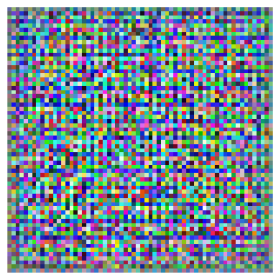

In [8]:
# Importation des bibliothèques nécessaires
import torch                  # Bibliothèque principale pour le calcul numérique
import torch.nn as nn        # Sous-module pour construire des réseaux de neurones
import torch.nn.functional as F  # Contient des fonctions utiles comme les fonctions d'activation
import numpy as np           # Bibliothèque pour les opérations sur les tableaux et matrices
import matplotlib.pyplot as plt  # Bibliothèque pour créer des visualisations

# Définition de la classe du générateur
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()  # Appelle le constructeur de la classe parente nn.Module

        # Définition des couches de convolution transposée
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)  # 1ère couche : entrée de 100 dimensions, sortie 512
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)  # 2ème couche : prend 512 canaux en entrée et produit 256 canaux
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)  # 3ème couche : prend 256 canaux et produit 128 canaux
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)    # 4ème couche : prend 128 canaux et produit 64 canaux
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)      # Couche finale : prend 64 canaux et produit 3 canaux (image RGB)

        # Définition des normalisations de batch
        self.bn1 = nn.BatchNorm2d(512)  # Normalisation après la 1ère couche
        self.bn2 = nn.BatchNorm2d(256)  # Normalisation après la 2ème couche
        self.bn3 = nn.BatchNorm2d(128)  # Normalisation après la 3ème couche
        self.bn4 = nn.BatchNorm2d(64)   # Normalisation après la 4ème couche

    def forward(self, x):
        # Méthode qui définit comment les données passent à travers le réseau (passage avant)
        x = F.relu(self.bn1(self.conv1(x)))  # Applique la 1ère couche de convolution transposée, normalisation et fonction d'activation ReLU
        x = F.relu(self.bn2(self.conv2(x)))  # Applique la 2ème couche de convolution transposée, normalisation et fonction d'activation
        x = F.relu(self.bn3(self.conv3(x)))  # Applique la 3ème couche de convolution transposée, normalisation et fonction d'activation
        x = F.relu(self.bn4(self.conv4(x)))  # Applique la 4ème couche de convolution transposée, normalisation et fonction d'activation
        x = torch.tanh(self.conv5(x))        # Applique la couche finale et utilise la fonction d'activation Tanh pour normaliser la sortie
        return x  # Renvoie l'image générée

# Création d'une instance du générateur
gnet = generatorNet()

# Test du générateur avec un batch de données aléatoires
y = gnet(torch.randn(10, 100, 1, 1))  # Passe 10 vecteurs aléatoires de taille 100
print(y.shape)  # Affiche la forme de la sortie (devrait être [10, 3, 64, 64])

# Préparation de la première image générée pour l'affichage
pic = y[0, :, :, :].squeeze().detach().numpy().transpose((1, 2, 0))  # Prend la première image et change la forme pour l'affichage
pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))  # Normalise l'image entre 0 et 1
plt.imshow(pic)  # Affiche l'image
plt.axis('off')  # Désactive les axes pour un affichage plus propre
plt.show()  # Affiche la figure


# Importation de modèles déjà entraînés

In [11]:
# Importation des bibliothèques nécessaires
import os  # Pour les opérations sur le système de fichiers
import torch  # Bibliothèque principale pour le calcul numérique
import torch.nn as nn  # Sous-module pour construire des réseaux de neurones

# Définition du chemin où les modèles seront sauvegardés ou chargés
path = r"C:\Users\jerem\Desktop\AIVANCITY\FREEFALL\PROJECTS\GAN_dog\models" 
os.makedirs(path, exist_ok=True)  # Crée le répertoire spécifié s'il n'existe pas déjà

# Définition des chemins pour les modèles du générateur et du discriminateur
model_path_gnet = os.path.join(path, "model_parameters_gnet_2.1.pth")  # Chemin pour le modèle du générateur
model_path_dnet = os.path.join(path, "model_parameters_dnet_2.1.pth")  # Chemin pour le modèle du discriminateur

# Instantiation des modèles
dnet = discriminatorNet()  # Crée une instance du discriminateur
gnet = generatorNet()      # Crée une instance du générateur

# Chargement des poids du modèle pour le GPU
dnet.load_state_dict(torch.load(model_path_dnet))  # Charge les paramètres du modèle du discriminateur
gnet.load_state_dict(torch.load(model_path_gnet))   # Charge les paramètres du modèle du générateur

# Si Utilisation sur le CPU de votre PC
# dnet.load_state_dict(torch.load(model_path_dnet, map_location=torch.device('cpu')))  # Charge pour CPU
# gnet.load_state_dict(torch.load(model_path_gnet, map_location=torch.device('cpu')))   # Charge pour CPU

# Envoi des modèles sur le dispositif (GPU ou CPU selon la disponibilité)
dnet = dnet.to(device)  # Déplace le modèle du discriminateur sur le GPU ou le CPU
gnet = gnet.to(device)  # Déplace le modèle du générateur sur le GPU ou le CPU

# Définition de la fonction de perte
lossfun = nn.BCELoss()  # Utilise la perte binaire cross-entropy pour les sorties de classification

# Configuration des optimisateurs pour le discriminateur et le générateur
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))  # Optimiseur Adam pour le discriminateur
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))  # Optimiseur Adam pour le générateur

# Affiche le nombre d'itérations par epoch dans le DataLoader
len(data_loader)  # Renvoie la longueur du DataLoader, c'est-à-dire le nombre de batches par epoch


C:\Users\jerem\AppData\Local\Temp\ipykernel_6012\1614239314.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dnet.load_state_dict(torch.load(model_path_dnet))  # Charge 

643

# Création de nouveaux Modèles

In [10]:
# Définition de la fonction de perte pour le modèle
lossfun = nn.BCELoss()  # Utilisation de la perte binaire cross-entropy (BCELoss) qui est couramment utilisée pour les modèles de classification binaire

# Instantiation du discriminateur et du générateur, et transfert vers le dispositif (GPU ou CPU)
dnet = discriminatorNet().to(device)  # Crée une instance du modèle discriminateur et le déplace vers le dispositif défini (GPU ou CPU)
gnet = generatorNet().to(device)      # Crée une instance du modèle générateur et le déplace vers le dispositif défini

# Configuration des optimisateurs pour le discriminateur et le générateur
# Utilisation de l'optimiseur Adam avec des paramètres spécifiques
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))  # Optimiseur pour le discriminateur
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))  # Optimiseur pour le générateur

# Affichage du nombre de batches dans le DataLoader
len(data_loader)  # Renvoie la longueur du DataLoader, c'est-à-dire le nombre total de batches par époque


643

# Entraînement des modèles

In [19]:
# Définir le nombre d'époques d'entraînement (nombre d'itérations globales sur l'ensemble des données)
num_epochs = 70  # Choisir un nombre d'épisodes adapté au temps que vous disposez pour exécuter le programme

# Initialiser des listes pour suivre la progression des pertes et les décisions du discriminateur
losses  = []
disDecs = []
training_images = []

# Activer le mode entraînement pour les réseaux discriminateur et générateur
dnet.train()
gnet.train()

# Boucle principale sur le nombre d'époques
for epochi in range(num_epochs):

    # Initialiser un compteur d'opérations (batches) pour l'affichage intermédiaire
    operations = 0

    # Boucle interne pour chaque batch de données
    for data, _ in data_loader:  # `_` signifie qu'on ignore les étiquettes si elles sont disponibles

        # Incrémenter le compteur d'opérations pour ce batch
        operations += 1

        # Transférer les données sur le dispositif (CPU ou GPU)
        data = data.to(device)
        # Créer des labels pour les vraies images (1) et les fausses images (0)
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)

        # Entraînement du discriminateur

        # Prédictions du discriminateur sur les vraies images
        pred_real = dnet(data)
        # Calcul de la perte pour les vraies images
        d_loss_real = lossfun(pred_real, real_labels)

        # Génération de fausses images par le générateur
        fake_data = torch.randn(batchsize, 100, 1, 1).to(device)  # Vecteur aléatoire pour générer des images
        fake_images = gnet(fake_data)
        # Prédictions du discriminateur sur les fausses images
        pred_fake = dnet(fake_images)
        # Calcul de la perte pour les fausses images
        d_loss_fake = lossfun(pred_fake, fake_labels)

        # Combinaison des deux pertes pour le discriminateur
        d_loss = d_loss_real + d_loss_fake

        # Backpropagation et optimisation pour le discriminateur
        d_optimizer.zero_grad()  # Réinitialiser les gradients
        d_loss.backward()        # Calculer les gradients
        d_optimizer.step()       # Mettre à jour les poids du discriminateur

        # Entraînement du générateur

        # Générer de nouvelles fausses images
        fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
        # Prédictions du discriminateur sur ces nouvelles fausses images
        pred_fake = dnet(fake_images)

        # Calcul de la perte pour le générateur (objectif : tromper le discriminateur)
        g_loss = lossfun(pred_fake, real_labels)

        # Backpropagation et optimisation pour le générateur
        g_optimizer.zero_grad()  # Réinitialiser les gradients
        g_loss.backward()        # Calculer les gradients
        g_optimizer.step()       # Mettre à jour les poids du générateur

        # Enregistrer les pertes pour les deux réseaux
        losses.append([d_loss.item(), g_loss.item()])

        # Évaluation des performances du discriminateur
        d1 = torch.mean((pred_real > 0.5).float()).detach()  # Précision pour les vraies images
        d2 = torch.mean((pred_fake > 0.5).float()).detach()  # Précision pour les fausses images
        disDecs.append([d1, d2])

        # Enregistrer une fausse image toutes les 20 opérations
        if operations % 20 == 0:
            training_images.append(fake_images[0])

    # Message de suivi pour afficher la progression de l'entraînement
    msg = f'Épisode {epochi + 1}/{num_epochs}'
    sys.stdout.write('\r' + msg)

# Conversion des listes de pertes et de décisions du discriminateur en tableaux numpy pour l'analyse
losses  = np.array(losses)
# disDecs = np.array(disDecs)


Épisode 70/70

# Affichage des résultats

NameError: name 'losses' is not defined

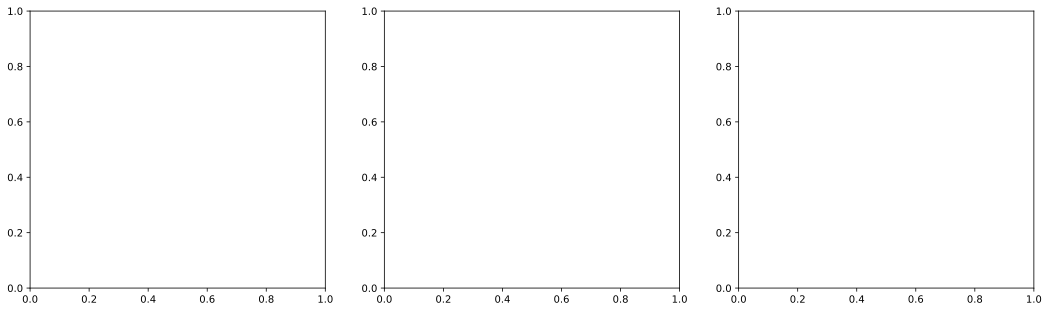

In [10]:
def smooth(x, k=15):
    """Fonction pour lisser une série temporelle de données.
    
    Args:
        x (np.ndarray): Les données à lisser.
        k (int): La taille de la fenêtre pour la moyenne mobile (par défaut: 15).
        
    Returns:
        np.ndarray: Les données lissées.
    """
    return np.convolve(x, np.ones(k)/k, mode='same')  # Convolution avec une fenêtre de moyennes pour lisser les données

# Création d'une figure et d'un ensemble d'axes pour les sous-graphes
fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # 1 ligne, 3 colonnes, taille de la figure (18, 5)

# Premier sous-graphe : Pertes des modèles
ax[0].plot(smooth(losses[:, 0]))  # Pertes du discriminateur lissées
ax[0].plot(smooth(losses[:, 1]))  # Pertes du générateur lissées
ax[0].set_xlabel('Batches')  # Étiquette de l'axe des x
ax[0].set_ylabel('Loss')  # Étiquette de l'axe des y
ax[0].set_title('Model loss')  # Titre du graphique
ax[0].legend(['Discriminator', 'Generator'])  # Légende pour identifier les courbes

# Deuxième sous-graphe : Relation entre les pertes du générateur et du discriminateur
ax[1].plot(losses[::5, 0], losses[::5, 1], 'k.', alpha=0.1)  # Points des pertes du générateur (y) et du discriminateur (x)
ax[1].set_xlabel('Discriminator loss')  # Étiquette de l'axe des x
ax[1].set_ylabel('Generator loss')  # Étiquette de l'axe des y

# Troisième sous-graphe (commenté) : Sortie du discriminateur
# ax[2].plot(smooth(disDecs[:, 0]))  # Sortie lissée du discriminateur pour les images réelles
# ax[2].plot(smooth(disDecs[:, 1]))  # Sortie lissée du discriminateur pour les images générées
# ax[2].set_xlabel('Epochs')  # Étiquette de l'axe des x
# ax[2].set_ylabel('Probability ("real")')  # Étiquette de l'axe des y
# ax[2].set_title('Discriminator output')  # Titre du graphique
# ax[2].legend(['Real', 'Fake'])  # Légende pour identifier les courbes

plt.show()  # Affichage de tous les graphiques


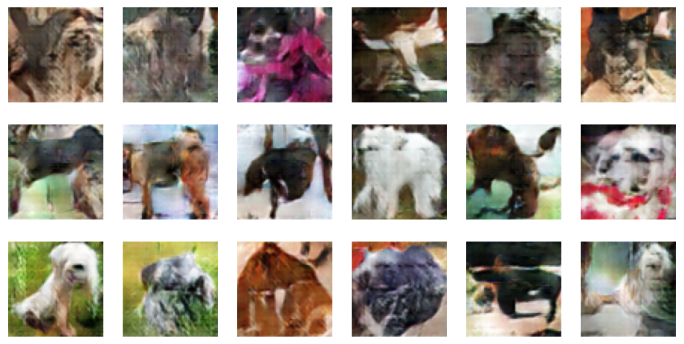

In [12]:
# Met le générateur en mode évaluation (désactive les opérations de dropout et de batch normalization)
gnet.eval()

# Génération de données aléatoires pour créer de fausses images
fake_data = gnet(torch.randn(batchsize, 100, 1, 1).to(device)).cpu()

# Création d'une figure avec des sous-graphes pour afficher les images générées
fig, axs = plt.subplots(3, 6, figsize=(12, 6))  # 3 lignes, 6 colonnes, taille de la figure (12, 6)

# Parcours de chaque sous-graphe pour afficher les images générées
for i, ax in enumerate(axs.flatten()):
    # Préparation de l'image à afficher
    pic = fake_data[i, :, ].detach().squeeze().numpy().transpose((1, 2, 0))  # Extraction de l'image, suppression des dimensions inutiles et transposition
    pic = (pic - np.min(pic)) / (np.max(pic) - np.min(pic))  # Normalisation de l'image pour l'affichage

    # Affichage de l'image dans le sous-graphe
    ax.imshow(pic, cmap='gray')  # Utilisation d'une carte de couleurs en niveaux de gris
    ax.axis('off')  # Désactivation des axes pour une meilleure présentation

# Affichage de toutes les images générées
plt.show()


# Sauvegarde des modèles

In [22]:
import os  # Importation du module os pour interagir avec le système de fichiers

# Spécification du chemin où les modèles seront sauvegardés
path = r"C:\Users\jerem\Desktop\AIVANCITY\FREEFALL\PROJECTS\GAN_dog\models"
os.makedirs(path, exist_ok=True)  # Création du répertoire si ce n'est pas déjà fait

# Définition des chemins pour les fichiers de sauvegarde des modèles
model_path_gnet = os.path.join(path, "model_parameters_gnet_2.1.pth")  # Chemin pour le modèle générateur
model_path_dnet = os.path.join(path, "model_parameters_dnet_2.1.pth")  # Chemin pour le modèle discriminateur

# Sauvegarde des poids et des biais du générateur
torch.save(gnet.state_dict(), model_path_gnet)  # Enregistrement des paramètres du générateur dans un fichier .pth

# Sauvegarde des poids et des biais du discriminateur
torch.save(dnet.state_dict(), model_path_dnet)  # Enregistrement des paramètres du discriminateur dans un fichier .pth


# Affichage de la progression des modèles durant l'entraînement

In [ ]:
from IPython.display import clear_output, display  # Importation des fonctions pour gérer l'affichage dans les notebooks Jupyter

# Activation du mode interactif pour les graphiques
plt.ion()

# Création d'une figure et d'un axe pour afficher les images
fig, ax = plt.subplots(figsize=(8, 8))  # Taille de la figure de 8x8 pouces
image_data = np.random.rand(64, 64, 3)  # Génération d'une image aléatoire de 64x64 pixels avec 3 canaux (RGB)
img = ax.imshow(image_data)  # Affichage de l'image aléatoire dans l'axe

# Boucle sur chaque image générée durant l'entraînement
for image in training_images:
    # Conversion de l'image PyTorch en un tableau NumPy pour l'affichage
    img_np = image.permute(1, 2, 0).cpu().detach().numpy()  # Réarrangement des dimensions pour correspondre à (hauteur, largeur, canaux)
    
    # Normalisation de l'image pour l'affichage
    img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))  # Normalisation entre 0 et 1
    
    plt.imshow(img_np)  # Affichage de l'image normalisée
    clear_output(wait=True)  # Effacement de la sortie précédente pour mettre à jour l'affichage
    display(fig)  # Affichage de la figure mise à jour

plt.ioff()  # Désactivation du mode interactif
plt.show()  # Affichage final de la figure avec toutes les images générées



KeyboardInterrupt: 

In [ ]:
#Félicitations si vous en êtes arrivés jusqu'ici !